## ewf-ext-02-02-01 Oil sheen of natural oil seepage with Sentinel-1

### <a name="service">Service definition

In [1]:
service = dict([('title', 'ewf-ext-02-02-01 Oil sheen of natural oil seepage with Sentinel-1'),
                ('abstract', 'ewf-ext-02-02-01 Oil sheen of natural oil seepage with Sentinel-1'),
                ('id', 'ewf-ext-02-02-01')])

### <a name="runtime">Runtime parameter definition

**Input identifiers**

This is the Sentinel-1 stack of products' identifiers

In [2]:
input_identifiers = ( 'S1B_IW_GRDH_1SDH_20171025T204653_20171025T204718_007991_00E1E2_CBD2', ) 

**Input references**

This is the Sentinel-1 stack catalogue references

In [3]:
input_references = ('https://catalog.terradue.com/sentinel1/search?uid=S1B_IW_GRDH_1SDH_20171025T204653_20171025T204718_007991_00E1E2_CBD2',) 

**Data path**

This path defines where the data is staged-in. 

In [4]:
data_path = "/workspace/data"

### <a name="workflow">Workflow

#### Import the packages required for processing the data

In [5]:
from snappy import jpy
from snappy import ProductIO

In [6]:
check_results = True

#### Read the products

In [7]:
s1meta = "manifest.safe"

products = []

for s1path in input_identifiers:

    s1prd= "%s/%s/%s.SAFE/%s" % (data_path, s1path, s1path, s1meta)
    reader = ProductIO.getProductReader("SENTINEL-1")
    product = reader.readProductNodes(s1prd, None)
    products.append(product)

#### Extract information about the Sentinel-1 GRD products:

In [8]:
for product in products:

    width = product.getSceneRasterWidth()
    height = product.getSceneRasterHeight()
    name = product.getName()
    band_names = product.getBandNames()
    print("Product: %s, %d x %d pixels" % (name, width, height))
    print("Bands:   %s" % (list(band_names)))
    

Product: S1B_IW_GRDH_1SDH_20171025T204653_20171025T204718_007991_00E1E2_CBD2, 25920 x 16645 pixels
Bands:   ['Amplitude_HH', 'Intensity_HH', 'Amplitude_HV', 'Intensity_HV']


#### Process the data

##### Check number of products

In [9]:
nProducts = len(products)

if nProducts == 1:
    
    product = products[0]
    
else:
    pass # TODO: merge

##### Subset

In [10]:
#aoi = 'POLYGON((-54.333 71.559, -49.842 71.559, -49.842 69.713, -54.333 69.713, -54.333 71.559))'
aoi = 'POLYGON((-54.333 71.558, -49.843 71.558, -49.843 69.713, -54.333 69.713, -54.333 71.558))'

In [11]:
from snappy import GPF
from snappy import HashMap
import snappy

WKTReader = snappy.jpy.get_type('com.vividsolutions.jts.io.WKTReader')

geom = WKTReader().read(aoi);


HashMap = jpy.get_type('java.util.HashMap')    
GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()

parameters = HashMap()
parameters.put('copyMetadata', True)
parameters.put('geoRegion', geom)

subset = GPF.createProduct('Subset', parameters, product)

##### Calibration

In [12]:
parameters = HashMap()

parameters.put('auxFile', 'Latest Auxiliary File')
parameters.put('outputSigmaBand', True)
#parameters.put('selectedPolarisations', 'HH')

calibrate = GPF.createProduct('Calibration', parameters, subset)

##### Speckle-Filter

In [14]:
parameters = HashMap()

parameters.put('filter','Lee')
parameters.put('filterSizeX','3')
parameters.put('filterSizeY','3')
parameters.put('dampingFactor','2')
parameters.put('estimateENL',True)
parameters.put('enl','1.0')
parameters.put('numLooksStr','1')
parameters.put('windowSize','7x7')
parameters.put('targetWindowSizeStr','3x3')
parameters.put('sigmaStr','0.9')
parameters.put('anSize','50')

filtered = GPF.createProduct('Speckle-Filter', parameters, calibrate)

##### Land-Sea-Mask

In [15]:
parameters = HashMap()

parameters.put('vectorFile', '/workspace/dev/ewf-ext-02-02-01/src/main/app-resources/notebook/libexec/land_vector/land.shp')
parameters.put('separateShapes', False)

addvector = GPF.createProduct('Import-Vector', parameters, filtered)

In [16]:
parameters = HashMap()

parameters.put('landMask', False)
parameters.put('useSRTM', False)
parameters.put('geometry', 'land')
parameters.put('invertGeometry', True)
parameters.put('shorelineExtension', 10)

landMasked = GPF.createProduct('Land-Sea-Mask', parameters, addvector)

##### Oil-Spill-Detection

In [17]:
parameters = HashMap()

parameters.put('sourceBands', 'Sigma0_HH,Sigma0_HV')
parameters.put('backgroundWindowSize', 61)
parameters.put('k', 2.0)

oildetection = GPF.createProduct('Oil-Spill-Detection', parameters, landMasked)

#####  Oil-Spill-Clustering

In [18]:
parameters = HashMap()

parameters.put('minClusterSizeInKm2', 0.1)

oilclust = GPF.createProduct('Oil-Spill-Clustering', parameters, oildetection)
name = oilclust.getName()
timestamp = name.split("_")[5] 
date = timestamp[:8]

In [19]:
#dir(oilclust)

In [20]:
band_names = list(oilclust.getBandNames())
print(band_names)

['Sigma0_HH', 'Sigma0_HH_oil_spill_bit_msk', 'Sigma0_HV', 'Sigma0_HV_oil_spill_bit_msk']


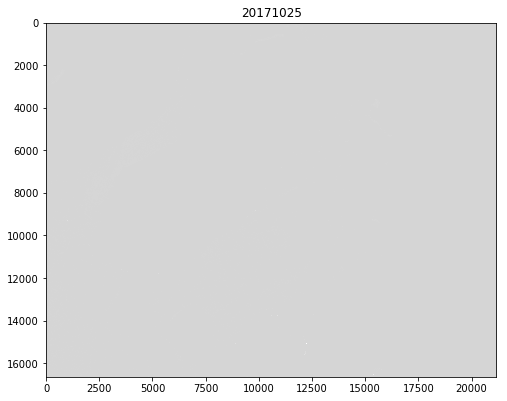

In [21]:
if check_results:
    import numpy as np
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.colors as colors
    import gc 

    %matplotlib inline

    def plotBand(product, band, vmin, vmax):
     
        band = product.getBand(band)

        w = band.getRasterWidth()
        h = band.getRasterHeight()

        band_data = np.zeros(w * h, np.float32)
        band.readPixels(0, 0, w, h, band_data)

        band_data.shape = h, w

        imgplot = plt.imshow(band_data, cmap=plt.cm.binary_r, vmin=vmin, vmax=vmax)

    
        return imgplot 


    fig = plt.figure(figsize=(20,20))
    i = 1

    a=fig.add_subplot(330+i)
    imgplot = plotBand(oilclust, 'Sigma0_HH', -25, 5)
    name = oilclust.getName()
    timestamp = name.split("_")[5] 
    date = timestamp[:8]
    a.set_title(date)
    i = i+1

    plt.tight_layout()
    fig = plt.gcf()
    plt.show()

    fig.clf()
    plt.close()
    gc.collect()

In [23]:
#oilclust.getName()

#####  Garbage collector

In [24]:
subset = None
addvector = None
landMasked = None
calibrate = None
oildetection = None
#oilclust = None

gc.collect()

0

#####  Save results

In [ ]:
 ProductIO.writeProduct(oilclust, oilclust.getName(), 'BEAM-DIMAP')

In [ ]:
# Ellipsoid-Correction-RD
'''
parameters = HashMap()

parameters.put('demName', 'GETASSE30')
parameters.put('imgResamplingMethod', 'BILINEAR_INTERPOLATION')

proj = '''GEOGCS["WGS84(DD)", DATUM["WGS84", SPHEROID["WGS84", 6378137.0, 298.257223563]], PRIMEM["Greenwich", 0.0], UNIT["degree", 0.017453292519943295], AXIS["Geodetic longitude", EAST], AXIS["Geodetic latitude", NORTH]]'''

parameters.put('mapProjection', proj)       # comment this line if no need to convert to UTM/WGS84, default is WGS84parameters.put('saveProjectedLocalIncidenceAngle', True)
parameters.put('saveSelectedSourceBand', True)

parameters.put('pixelSpacingInMeter', 25.0)

output = GPF.createProduct('Terrain-Correction', parameters, source)
'''